In [1]:
# %pip install openai==1.76.0 pandas ipywidgets --quiet

In [1]:
import base64
import getpass
import json
import re
from datetime import datetime, timedelta

import ipywidgets as widgets
import openai
import pandas as pd
from IPython.display import Image, display

In [2]:
api_key = getpass.getpass("OpenAI API key: ").strip()
client = openai.OpenAI(api_key=api_key)

OpenAI API key:  ········


In [3]:
# Initialize Empty Pantry Database
pantry_db = pd.DataFrame(columns=["Item Name", "Quantity Amount", "Quantity Unit", "Count", "Date Added", "Expected Expiration"])

In [4]:
def upload_food_image():
    uploader = widgets.FileUpload(accept="image/*", multiple=False)
    display(uploader)
    return uploader

In [5]:
# Function to Classify Food Items from Uploaded Image with Chain-of-Thought Prompt
def classify_food_items(file_upload):
    if not file_upload.value:
        raise Exception("No file uploaded.")

    uploaded_file = file_upload.value[0]
    file_bytes = uploaded_file["content"]

    base64_image = base64.b64encode(file_bytes).decode("utf-8")
    data_url = f"data:{uploaded_file['type']};base64,{base64_image}"

    today_str = datetime.today().strftime("%Y-%m-%d")

    prompt_text = (
        f"You are a grocery inventory assistant helping track food items.\n\n"
        f"Today's date is {today_str}.\n\n"
        "Instructions:\n"
        "- Carefully examine the image for any visible food products.\n"
        "- For each item identified, follow this detailed reasoning:\n"
        "  1. Read all visible text and branding on the packaging to identify the full item name.\n"
        "     - Include brand and type (e.g., 'Oasis Orange Juice', 'Great Value Basmati Rice').\n"
        "  2. Scan the package for quantity indicators. These are often found next to weight (g, kg), volume (ml, L), or counts (e.g., '6-pack').\n"
        "     - Convert all quantity details into a consistent quantity string (e.g., '500 g pack', '1.5 L bottle', '6 eggs').\n"
        "     - Extract numerical value and unit separately.\n"
        "       Examples:\n"
        "         '1.5 L bottle' -> quantity_amount: 1.5, quantity_unit: 'L'\n"
        "         '6 pack' -> quantity_amount: 6, quantity_unit: 'units'\n"
        "  3. Visually count the number of identical items when possible.\n"
        "     - If multiple identical units (like two chocolate bars or three peppers) are visible, count them.\n"
        "     - Do not rely solely on printed text; use the visual layout of the image.\n"
        "     - Include a field: 'count': <integer>.\n"
        "  4. Look for any printed expiration date.\n"
        "     - Accept 'Best Before', 'Use By', 'BB', or 'Expiry'.\n"
        "     - If no printed date, estimate based on type:\n"
        "         - Green banana: +7 days\n"
        "         - Yellow banana: +5 days\n"
        "         - Black banana: +2 days\n"
        "         - Milk: +7 days\n"
        "         - Yogurt: +10 days\n"
        "         - Jarred sauces: +180 days\n"
        "         - Staples (rice, oats, sugar, flour, lentils): +365 days\n"
        "- Do not assign a date earlier than today's date.\n\n"
        "Format your answer as a STRICT JSON array ONLY like this:\n"
        "[\n"
        '  {"item_name": <string>, "quantity": <string>, "count": <integer>, "expiration_date": <YYYY-MM-DD>},\n'
        "  ...\n"
        "]\n"
        "DO NOT include any explanation before or after the JSON."
    )

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text},
                    {"type": "image_url", "image_url": {"url": data_url}}
                ]
            }
        ]
    )

    return response.choices[0].message.content

In [6]:
# Function to Parse OpenAI Response and Store in Database
def parse_and_store(result_text, pantry_db):
    today = datetime.today().date()
    records = []

    cleaned_text = result_text.strip()
    if cleaned_text.startswith("```json"):
        cleaned_text = cleaned_text.replace("```json", "").strip()
    if cleaned_text.startswith("```"):
        cleaned_text = cleaned_text.replace("```", "").strip()
    if cleaned_text.endswith("```"):
        cleaned_text = cleaned_text[:-3].strip()

    try:
        items = json.loads(cleaned_text)
    except json.JSONDecodeError:
        print("Failed to decode JSON from OpenAI response.")
        return pantry_db

    for item in items:
        item_name = item.get("item_name", "Unknown")
        quantity = item.get("quantity", "1 unit")
        count = item.get("count", 1)
        expiration_date = item.get("expiration_date", None)

        match = re.match(r"([\d\.]+)\s*(\w+)?", quantity)
        if match:
            quantity_amount = float(match.group(1))
            quantity_unit = match.group(2) if match.group(2) else "unit"
        else:
            quantity_amount = 1
            quantity_unit = "unit"

        if expiration_date:
            expected_expiry = pd.to_datetime(expiration_date).date()
        else:
            expected_expiry = today + timedelta(days=7)

        records.append({
            "Item Name": item_name,
            "Quantity Amount": quantity_amount,
            "Quantity Unit": quantity_unit,
            "Count": count,
            "Date Added": today,
            "Expected Expiration": expected_expiry
        })

    if not pantry_db.empty:
        pantry_db = pd.concat([pantry_db, pd.DataFrame(records)], ignore_index=True)
    else:
        pantry_db = pd.DataFrame(records)

    return pantry_db

In [7]:
def generate_recipe_from_pantry(pantry_db):
    ingredient_list = ", ".join(pantry_db["Item Name"].tolist())

    prompt = (
        f"You are a creative chef.\n"
        f"Using ONLY these available ingredients: {ingredient_list},\n"
        f"suggest a realistic, known and tasty recipe.\n"
        f"Keep it simple, list the ingredients and clear steps.\n"
        f"At the end, suggest a dish name."
    )

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}]
    )

    recipe_text = response.choices[0].message.content
    return recipe_text

In [9]:
# # Function to Generate Image of the Dish
# def generate_recipe_image(dish_name):
#     result = client.images.generate(
#         model="gpt-image-1",
#         prompt=f"A image of a realistic finished dish of {dish_name} beautifully plated.",
#     )
#     image_base64 = result.data[0].b64_json
#     image_bytes = base64.b64decode(image_base64)

#     with open("generated_dish.png", "wb") as f:
#         f.write(image_bytes)

#     return "generated_dish.png"

In [8]:
def generate_recipe_image(dish_name):
    result = client.images.generate(
        model="dall-e-2",
        prompt=f"A beautifully plated dish of {dish_name} on a blank white background, realistic photography, vibrant colours, appetizing food presentation, minimalistic style.",
        response_format="b64_json",
        size="512x512"
    )
    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)

    with open("generated_dish.png", "wb") as f:
        f.write(image_bytes)

    return "generated_dish.png"

In [9]:
pantry_db

,Item Name,Quantity Amount,Quantity Unit,Count,Date Added,Expected Expiration


### **Image Upload**

In [10]:
uploader = upload_food_image()

FileUpload(value=(), accept='image/*', description='Upload')

In [11]:
if uploader.value:
    result_text = classify_food_items(uploader)
    pantry_db = parse_and_store(result_text, pantry_db)
    print("\n Current Pantry Database:")
    display(pantry_db)
else:
    print("Please upload an image first.")


 Current Pantry Database:


,Item Name,Quantity Amount,Quantity Unit,Count,Date Added,Expected Expiration
0,Oikos Greek Yogurt,750.0,g,1,2025-05-12,2025-05-22
1,12 Large Size Eggs,12.0,eggs,1,2025-05-12,2025-05-29
2,Fairlife 2% Milk,1.5,L,1,2025-05-12,2025-05-19
3,Cremini Mushrooms,227.0,g,2,2025-05-12,2025-05-16
4,Kirkland Chicken Breasts,1.7,kg,1,2025-05-12,2025-05-22
5,La Stella Paneer,200.0,g,2,2025-05-12,2025-11-08
6,Yellow Bell Pepper,1.0,unit,1,2025-05-12,2025-05-17
7,Orange Bell Pepper,1.0,unit,2,2025-05-12,2025-05-17
8,Lindt Excellence Madagascar 70% Cacao,100.0,g,2,2025-05-12,2026-05-12
9,Poblano Peppers,1.0,unit,2,2025-05-12,2025-05-17


In [30]:
uploader = upload_food_image()

FileUpload(value=(), accept='image/*', description='Upload')

In [31]:
if uploader.value:
    result_text = classify_food_items(uploader)
    pantry_db = parse_and_store(result_text, pantry_db)
    print("\n Current Pantry Database:")
    display(pantry_db)
else:
    print("Please upload an image first.")


 Current Pantry Database:


,Item Name,Quantity Amount,Quantity Unit,Count,Date Added,Expected Expiration
0,Plain Greek Yogurt,750.0,g,1,2025-05-11,2025-05-21
1,Large Eggs,12.0,pack,1,2025-05-11,2025-06-15
2,Cremini Mushrooms,227.0,g,2,2025-05-11,2025-05-18
3,Fairlife Milk,1.5,L,1,2025-05-11,2025-05-18
4,Chicken Breast,1.0,kg,1,2025-05-11,2025-05-14
5,Yellow Bell Pepper,1.0,unit,1,2025-05-11,2025-05-18
6,Orange Bell Pepper,1.0,unit,2,2025-05-11,2025-05-18
7,Tre Stelle Paneer,200.0,g,2,2025-05-11,2025-11-07
8,Strawberries,454.0,g,1,2025-05-11,2025-05-18
9,Lindt Excellence Madagascar 70% Cacao,100.0,g,2,2025-05-11,2026-05-11


In [12]:
recipe = generate_recipe_from_pantry(pantry_db)
print("Suggested Recipe:\n")
print(recipe)

Suggested Recipe:

Certainly! With the ingredients you've listed, I'll create a flavorful and straightforward recipe that combines savory and creamy elements for a delightful meal. 

### Creamy Chicken & Bell Pepper Skillet

#### Ingredients:
- 2 Kirkland Chicken Breasts, sliced
- 1 cup Oikos Greek Yogurt
- 1 cup Fairlife 2% Milk
- 1 cup Cremini Mushrooms, sliced
- 1 Yellow Bell Pepper, sliced
- 1 Orange Bell Pepper, sliced
- 1 Poblano Pepper, sliced
- 100g La Stella Paneer, cubed
- 2 tablespoons olive oil
- Salt and pepper to taste
- A sprinkle of Lindt Excellence Madagascar 70% Cacao (for garnish, optional)
- Fresh Driscoll's Raspberries and Strawberries (for serving)

#### Steps:
1. **Prepare the Ingredients:**
   - Slice the Kirkland Chicken Breasts into thin strips.
   - Slice the Cremini Mushrooms, Yellow Bell Pepper, Orange Bell Pepper, and Poblano Pepper.
   - Cube the La Stella Paneer.

2. **Cook the Chicken:**
   - Heat a tablespoon of olive oil in a large skillet over medium

In [33]:
last_line = recipe.strip().split("\n")[-1]
dish_name = last_line.replace("Dish Name: ", "").strip()


 Updated Image of the Dish:


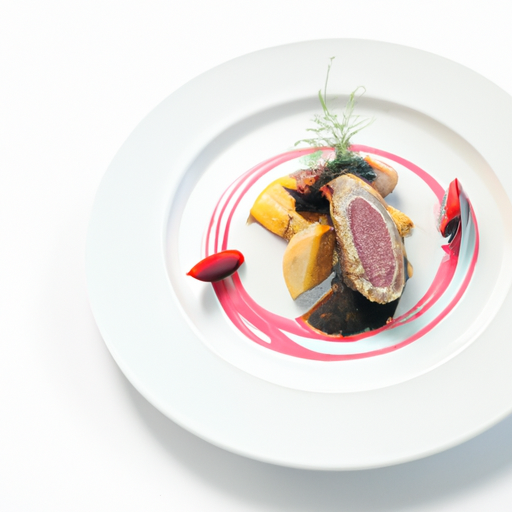

In [34]:
image_path = generate_recipe_image(dish_name)
print("\n Updated Image of the Dish:")
display(Image(filename=image_path))

In [ ]:
# Step 10: (Optional) Save Database to CSV
# pantry_db.to_csv("my_pantry_database.csv", index=False)